In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
%matplotlib inline
import random
import json

In [3]:
# Read in data 
f = open(r'deliveryDatasetChallenge.json')   # open the file
raw_data = json.load(f) # load data
columns = list(raw_data.keys())[0].split(';') # extract the attribute name and transform it to a list

# reformat the data records and collect them in a list
ls_record = []
for record in list(list(raw_data.values())[0].values()):
    ls_record.append(record.split(';'))
# transform the records into a dataframe
raw_df = pd.DataFrame(ls_record, columns=columns)
raw_df.head()

,anonID,birthdate,routeDate,region,gender,areaWealthLevel,areaPopulation,badWeather,weatherRestrictions,routeTotalDistance,numberOfShops,marketShare,avgAreaBenefits,timeFromAvg,advertising,employeeLYScore,employeeTenure,employeePrevComps,success
0,XLKC1691,23/10/1969,19/05/2020,NA,M,Mid,30.66,No,No,28.3,26,49,18.9,0.35,3,4,1,1,NA
1,KANY6459,14/04/1976,19/05/2020,LATAM,M,Mid,52.5,No,No,21.3,28,96,14.28,0.47,3,4,3,2,NA
2,YCOG1417,16/05/1970,11/05/2020,AMESA,M,Mid,46.58,No,No,31.9,23,71,18.67,0.02,3,4,3,2,NA
3,LRDT1582,26/11/1965,11/05/2020,APAC,M,Mid,5.2,No,No,25.1,27,79,14.99,-0.07,3,3,2,1,NA
4,NVNN3276,14/07/1988,12/05/2020,Europe,M,Mid,5.2,No,No,26.4,26,67,21.71,0.3,3,4,1,2,NA


In [4]:
# check dataframe dimension
print("Row count: %d" % raw_df.shape[0])
print("Column count: %d" % raw_df.shape[1])

Row count: 29389
Column count: 19


### Imputation

In [5]:
# convert the missing value "NA" from string to null data
raw_df = raw_df.replace({'NA':np.nan})
# check missing values for all the attributes
raw_df.isnull().sum()

anonID                     0
birthdate                  0
routeDate               5047
region                  8773
gender                     0
areaWealthLevel         2881
areaPopulation             0
badWeather                 0
weatherRestrictions        0
routeTotalDistance         0
numberOfShops              0
marketShare                0
avgAreaBenefits            8
timeFromAvg            11618
advertising                0
employeeLYScore            0
employeeTenure             0
employeePrevComps          0
success                 5878
dtype: int64

In [6]:
# convert all the string to the proper datatype
raw_df['birthdate'] = pd.to_datetime(raw_df['birthdate'], format="%d/%m/%Y")
raw_df['routeDate'] = pd.to_datetime(raw_df['routeDate'], format="%d/%m/%Y")
for col in ['areaPopulation', 'routeTotalDistance', 'numberOfShops','marketShare', 'avgAreaBenefits', 'timeFromAvg', 'advertising',
       'employeeLYScore', 'employeeTenure', 'employeePrevComps', 'success']:
    raw_df[col] = pd.to_numeric(raw_df[col])
raw_df.dtypes

anonID                         object
birthdate              datetime64[ns]
routeDate              datetime64[ns]
region                         object
gender                         object
areaWealthLevel                object
areaPopulation                float64
badWeather                     object
weatherRestrictions            object
routeTotalDistance            float64
numberOfShops                   int64
marketShare                     int64
avgAreaBenefits               float64
timeFromAvg                   float64
advertising                     int64
employeeLYScore                 int64
employeeTenure                  int64
employeePrevComps               int64
success                       float64
dtype: object

C:\Users\zouqin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\zouqin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


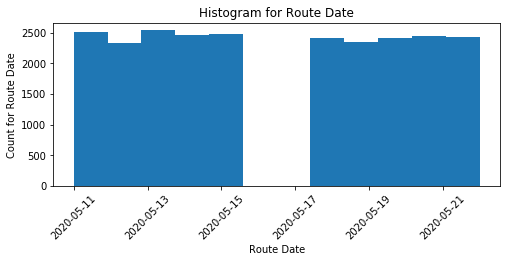

In [7]:
plt.figure(figsize=(8,3))
plt.hist(raw_df.routeDate, bins=12)
plt.xticks(rotation=45)
plt.xlabel('Route Date')
plt.ylabel('Count for Route Date')
plt.title("Histogram for Route Date")
plt.show()

In [10]:
# convert the driver birthday to age at routing date
# to calcuate the driver's age at routing date, first impute the routeDate using
# since these days are evenly distributed, the routeDate will be imputed by random selected from existing data
df = raw_df.copy()

# randomise missing data for DataFrame (within a column)
def randomMissingData(cols, df):
    df2 = df.copy()
    for col in cols:
        data = df2[col]
        mask = data.isnull()
        samples = random.choices(data[~mask].values , k = mask.sum() )
        df2.loc[mask, col] = samples
    return df2
df = randomMissingData(['routeDate'], df)

# add the weekday of routing
df['routeWeekday'] = df['routeDate'].dt.weekday
df['routeWeekday'].replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thur', 4:'Fri'}, inplace=True)

# Calcuate age for employee
df['EmployeeAge'] = (df['routeDate'] - df['birthdate'])/np.timedelta64(1, 'Y')
# round the age
df['EmployeeAge'] = df['EmployeeAge'].round(2)

#### Since weekday information has been extracted from route date and route date as a calendar date itself doesn't have pattern that we can trace for future reference, we will drop routeDate, birthdate and anonID since they cann't provide insightful information for model building

In [11]:
# Drop anonID and routeDate
df.drop(['anonID', 'routeDate', 'birthdate'], axis=1, inplace=True) 

In [14]:
# use one-hot encoding transform categorical data
def oneHotEncoder(X, col):
    return pd.get_dummies(X[col], drop_first=True)

# identify the categorical variables in the data set
# employeeTenure will not be classified as categorical variable since the value of the feature alligned with the level of employee experience
# and thus can be used to quantifiled the level of experience.
cat_cols = ['region', 'gender', 'areaWealthLevel', 'badWeather', 'weatherRestrictions', 'routeWeekday']

# identify continuous variables
con_cols = [col for col in df.columns if col not in cat_cols]
# taking out the target valuable since it cann't be use to impute other variable
con_cols.remove('success')

# convert categorical variables to dummie variables
df_onehot = oneHotEncoder(df, cat_cols)
df_onehot = df[con_cols].join(df_onehot)

# calculate the heighest correlation for each feature that has missing values
#imputed_cols = df_onehot.columns[df_onehot.isnull().any()].tolist()
imputed_cols = ['avgAreaBenefits', 'timeFromAvg','region_APAC', 'region_Europe', 'region_LATAM', 'areaWealthLevel_Low',
       'areaWealthLevel_Mid']
Highest_corrs = []
id_highest = []
df_corr = abs(df_onehot.corr())
for col in imputed_cols:
    # dropp the target feature itself from correlation matrix
    Highest_corrs.append(df_corr[col].drop(index=col).max())
    # record the feature that has the highest corr with target feature
    id_highest.append(df_corr[col].drop(index=col).idxmax())
df_max_corr = pd.DataFrame({'num feature':imputed_cols, 'Highest abs Corr': Highest_corrs, 'Max Corr Col':id_highest})
df_max_corr.sort_values('Highest abs Corr', inplace=True, ascending=False)
df_max_corr.head(8)

,num feature,Highest abs Corr,Max Corr Col
5,areaWealthLevel_Low,0.489060,areaWealthLevel_Mid
6,areaWealthLevel_Mid,0.489060,areaWealthLevel_Low
0,avgAreaBenefits,0.337128,advertising
1,timeFromAvg,0.251698,employeePrevComps
2,region_APAC,0.226454,region_Europe
3,region_Europe,0.226454,region_APAC
4,region_LATAM,0.193621,region_APAC


#### Since there is no obvious relation between the features that need to impute and other features, all the features will be imputed using gerneral statiscs.

In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

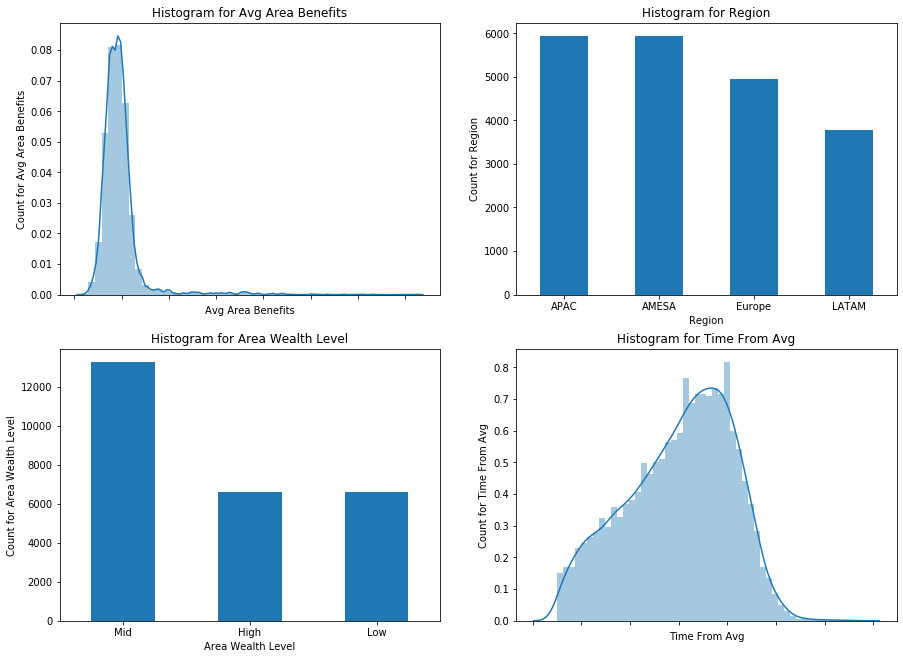

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# Graph Avg Area Benefis
sns.distplot(ax=axes[0,0], a=df.avgAreaBenefits)
xlabels = axes[0,0].get_xticklabels()
axes[0,0].set_title("Histogram for Avg Area Benefits")
axes[0,0].set_xlabel('Avg Area Benefits')
axes[0,0].set_ylabel('Count for Avg Area Benefits')
axes[0,0].set_xticklabels(xlabels)

# Graph Region Counts
df.region.value_counts().plot.bar(ax=axes[0,1])
xlabels = axes[0,1].get_xticklabels()
axes[0,1].set_title("Histogram for Region")
axes[0,1].set_xlabel('Region')
axes[0,1].set_ylabel('Count for Region')
axes[0,1].set_xticklabels(xlabels, rotation=0)

# Graph Area Wealth Level
df.areaWealthLevel.value_counts().plot.bar(ax=axes[1,0])
xlabels = axes[1,0].get_xticklabels()
axes[1,0].set_title("Histogram for Area Wealth Level")
axes[1,0].set_xlabel('Area Wealth Level')
axes[1,0].set_ylabel('Count for Area Wealth Level')
axes[1,0].set_xticklabels(xlabels, rotation=0)

# Graph Time From Avg
sns.distplot(df.timeFromAvg, ax=axes[1,1])
xlabels = axes[1,1].get_xticklabels()
axes[1,1].set_title("Histogram for Time From Avg")
axes[1,1].set_xlabel('Time From Avg')
axes[1,1].set_ylabel('Count for Time From Avg')
axes[1,1].set_xticklabels(xlabels)

plt.show()


In [17]:
# The distribution of Avg Area Benefit generally follows Gaussian Distribution. Some areas yields substantially more more 
# benifits than others that might affect the average value. Thus median would be a better option for impute the missing value 
# for Avg Area Benefits.
df['avgAreaBenefits'] = df['avgAreaBenefits'].fillna(df['avgAreaBenefits'].median())

# The distribution of Region seems very random. APAC and AMESA are the most active regions and LATAM is the lest active region. 
# Thus the missing values will be imputed by random choices of existing data.
df = randomMissingData(['region'], df)

# From the graph about we can see that majority of the area are under middle weath level. Thus AreaWealthLevel will be imputed 
# its mode, which is "Mid"
df['areaWealthLevel'] = df['areaWealthLevel'].fillna('Mid')

# The distribution of time from average deliver time skew to the right. Median will be used to impute this variable 
df['timeFromAvg'] = df['timeFromAvg'].fillna(df['timeFromAvg'].median())

df.isnull().sum()

region                    0
gender                    0
areaWealthLevel           0
areaPopulation            0
badWeather                0
weatherRestrictions       0
routeTotalDistance        0
numberOfShops             0
marketShare               0
avgAreaBenefits           0
timeFromAvg               0
advertising               0
employeeLYScore           0
employeeTenure            0
employeePrevComps         0
success                5878
routeWeekday              0
EmployeeAge               0
dtype: int64

In [18]:
df['areaWealthLevel'].mode()

0    Mid
dtype: object

# Logistics Regression

In [19]:
# In order to identify the numerical features that has low variance, data need to be normalized first through min-max transformation
def MinMaxTransform(conti_variable, X):
    minVec = X[conti_variable].min()
    maxVec = X[conti_variable].max()
    X[conti_variable] = ((X[conti_variable] - minVec)/(maxVec-minVec))
    return X[conti_variable]

def normalization(conti_variable, df):
    return (df[conti_variable]-df[conti_variable].mean())/df[conti_variable].std()

# convert categorical variables to dummie variables
df_cat = pd.get_dummies(df[cat_cols], drop_first=True)

# normalize the continuous data
df_con = normalization(con_cols, df)
df_X = df_con.join(df_cat)
df_clean = df_X.join(df.success)
df_clean.shape

(29389, 25)

In [20]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import itertools

In [21]:
# Split train and test set
x_test = df_X[df['success'].isnull()]
y_test = df['success'][df['success'].isnull()]
X = df_X[df['success'].notnull()]
y = df['success'][df['success'].notnull()]
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=7)
print("Train data size: %d" % len(x_train))
print("Validation data size: %d" % len(x_val))
print("Test data size: %d" % len(x_test))

Train data size: 17633
Validation data size: 5878
Test data size: 5878


In [37]:
df['success'].value_counts()

1.0    22647
0.0      864
Name: success, dtype: int64

In [36]:
# Build logistic classifier
model_logistic_base = LogisticRegression()

# Fit the model
model_logistic_base.fit(x_train, y_train)
pred_logi_base = model_logistic_base.predict(x_val)
tn, fp, fn, tp = confusion_matrix(y_val, pred_logi_base).ravel()

#print(tn, fp, fn, tp)
print("Precision: %f" % (tp/(tp+fn)))
confusion_matrix(y_val, pred_logi_base)

print('Prediction accuracy of best logistic regression model:', accuracy_score(y_val, pred_logi_base))
print('The f1 score of the model is:', f1_score(y_val, pred_logi_base))
print('AUROC fo the model is:', roc_auc_score(y_val, model_logistic_base.predict_proba(x_val)[:,1]))

Precision: 0.999647
Prediction accuracy of best logistic regression model: 0.9632528070772371
The f1 score of the model is: 0.9812824956672443
AUROC fo the model is: 0.7642727968741749


Best number of features to use: 6
The f1 score of the model is: 0.9812824956672443
AUROC fo the model is: 0.7642727968741749


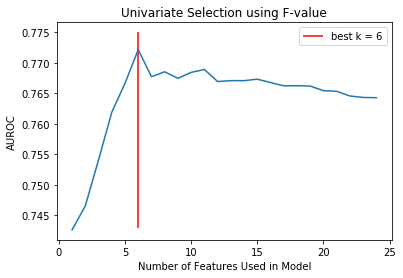

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

# define a list to hold the auroc value for different number of varialbes (k)
auroc_list = []
# define the number of variables that we what to test for each trial
k_list = np.arange(1,25,1)

# applied Univariate Selection using f-value
for k in k_list:
    # feature extraction
    UniSelect = SelectKBest(score_func=f_classif, k=k)
    fit = UniSelect.fit(X, y)
    # identified the selected features 
    sel_fea = X.columns[fit.get_support()]

    # Build logistic classifier
    model_logistic = LogisticRegression()

    # Fit the model
    model_logistic.fit(x_train[sel_fea], y_train)
    pred_logi = model_logistic.predict(x_val[sel_fea])
    tn, fp, fn, tp = confusion_matrix(y_val, pred_logi).ravel()
    auroc = roc_auc_score(y_val, model_logistic.predict_proba(x_val[sel_fea])[:,1])
    auroc_list.append(auroc)
    
plt.figure(figsize=(6,4))
plt.plot(k_list, auroc_list)
plt.xlabel("Number of Features Used in Model")
plt.ylabel("AUROC")
plt.title("Univariate Selection using F-value")
plt.vlines(6, ymin=0.743, ymax=0.775, label='best k = 6', color='r')
plt.legend()

best_k = k_list[auroc_list.index(max(auroc_list))]
print('Best number of features to use: %d' % best_k)
print('The f1 score of the model is:', f1_score(y_val, pred_logi))
print('AUROC fo the model is:', roc_auc_score(y_val, model_logistic.predict_proba(x_val[sel_fea])[:,1]))

In [24]:
# feature extraction
UniSelect = SelectKBest(score_func=f_classif, k=6)
fit_logi = UniSelect.fit(X, y)
# identified the selected features 
sel_fea = X.columns[fit_logi.get_support()]
# summarize selected features
indice_lr = np.argsort(fit_logi.scores_)
print("The selected features according to f-value are:")
print(list(sel_fea))

The selected features according to f-value are:
['areaPopulation', 'avgAreaBenefits', 'timeFromAvg', 'advertising', 'employeeLYScore', 'weatherRestrictions_Yes']


Text(0.5, 0, 'ANOVA F-value')

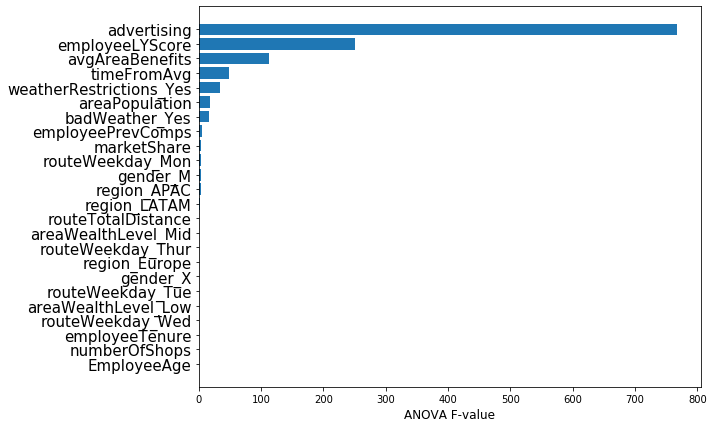

In [55]:
# Feature Importance According to F-value:
plt.figure(figsize=(9,7))
plt.barh(X.columns[indice_lr], fit_logi.scores_[indice_lr])
plt.yticks(fontsize=15)
plt.xlabel('ANOVA F-value', fontsize=12)

In [26]:
# Build logistic classifier
best_logi = LogisticRegression()

# Fit the model
best_logi.fit(x_train[sel_fea], y_train)
pred_logi_best = best_logi.predict(x_val[sel_fea])
tn, fp, fn, tp = confusion_matrix(y_val, pred_logi_best).ravel()

#print(tn, fp, fn, tp)
print(confusion_matrix(y_val, pred_logi_best))
print("Precision: %f" % (tp/(tp+fn)))
confusion_matrix(y_val, pred_logi_best)

print('The f1 score of the model is:', f1_score(y_val, pred_logi_best))
print('AUROC fo the model is:', roc_auc_score(y_val, best_logi.predict_proba(x_val[sel_fea])[:,1]))
print('Prediction accuracy of best logistic regression model:', accuracy_score(y_val, pred_logi_best))

[[   0  214]
 [   2 5662]]
Precision: 0.999647
The f1 score of the model is: 0.9812824956672443
AUROC fo the model is: 0.7721442856011405
Prediction accuracy of best logistic regression model: 0.9632528070772371


## Random Forest

In [433]:
# Build RandomForest classifier pipeline
parameters = {'n_estimators':np.arange(2,31,2), 'max_features':np.arange(2,15,2), 'criterion': ['gini', 'entropy']}
model_RF = GridSearchCV(RandomForestClassifier(), parameters, cv=4)
model_RF.fit(x_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [434]:
model_RF.best_params_

{'criterion': 'gini', 'max_features': 12, 'n_estimators': 10}

In [50]:
best_rf = RandomForestClassifier(criterion='gini', max_features=12, n_estimators=10)
best_rf.fit(x_train, y_train)
pred_rf = best_rf.predict(x_val)
print(confusion_matrix(y_val, pred_rf))
print('The f1 score of the model is:', f1_score(y_val, pred_rf))
print('The ROC socore of the best Random Forest model is: {}'.format(roc_auc_score(y_val, best_rf.predict_proba(x_val)[:,1])))
print('Prediction accuracy of best RandomForest model:', accuracy_score(y_val, pred_rf))

[[  58  156]
 [  16 5648]]
The f1 score of the model is: 0.9850017439832577
The ROC socore of the best Random Forest model is: 0.83841090144675
Prediction accuracy of best RandomForest model: 0.9707383463763185


Text(0.5, 0, 'importance score random forest')

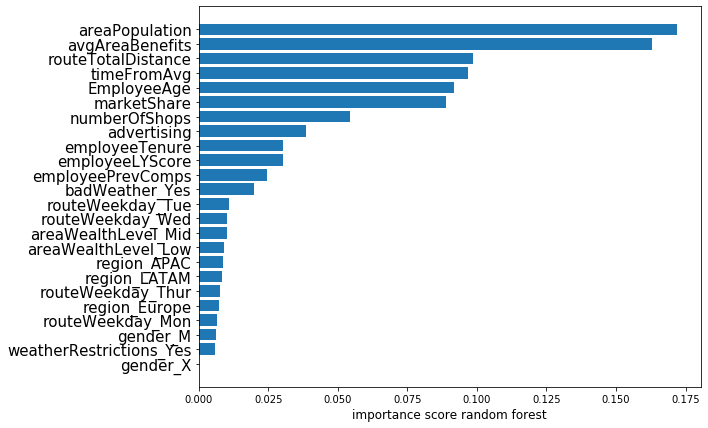

In [52]:
indice_rf = np.argsort(best_rf.feature_importances_)
plt.figure(figsize=(9,7))
plt.barh(X.columns[indice_rf], best_rf.feature_importances_[indice_rf])
plt.yticks(fontsize=15)
plt.xlabel('importance score random forest', fontsize=12)

In [447]:
X.columns[indice_rf][::-1]

Index(['areaPopulation', 'avgAreaBenefits', 'timeFromAvg', 'marketShare',
       'routeTotalDistance', 'EmployeeAge', 'numberOfShops', 'advertising',
       'employeeLYScore', 'employeeTenure', 'employeePrevComps',
       'badWeather_Yes', 'weatherRestrictions_Yes', 'areaWealthLevel_Mid',
       'region_LATAM', 'routeWeekday_Thur', 'routeWeekday_Tue',
       'routeWeekday_Mon', 'routeWeekday_Wed', 'region_Europe',
       'areaWealthLevel_Low', 'region_APAC', 'gender_M', 'gender_X'],
      dtype='object')

In [449]:
# Build RandomForest classifier pipeline
sel_fea_rf = ['areaPopulation', 'avgAreaBenefits', 'timeFromAvg', 'marketShare',
       'routeTotalDistance', 'EmployeeAge', 'numberOfShops', 'advertising',
       'employeeLYScore', 'employeeTenure', 'employeePrevComps',
       'badWeather_Yes', 'weatherRestrictions_Yes']
parameters = {'n_estimators':np.arange(2,31,2), 'max_features':np.arange(2,14,2), 'criterion': ['gini', 'entropy']}
model_RF = GridSearchCV(RandomForestClassifier(), parameters, cv=4)
model_RF.fit(x_train[sel_fea_rf], y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [451]:
model_RF.best_params_

{'criterion': 'entropy', 'max_features': 10, 'n_estimators': 16}

In [458]:
best_rf2 = RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=16)
best_rf2.fit(x_train[sel_fea_rf], y_train)
pred_rf2 = best_rf2.predict(x_val[sel_fea_rf])
print(confusion_matrix(y_val, pred_rf2))
print('The f1 score of the model is:', f1_score(y_val, pred_rf2))
print('The ROC socore of the best Random Forest model is: {}'.format(roc_auc_score(y_val, best_rf2.predict_proba(x_val[sel_fea_rf])[:,1])))
print('Prediction accuracy of best RandomForest model:', accuracy_score(y_val, pred_rf2))

[[  71  143]
 [   7 5657]]
The f1 score of the model is: 0.9869155617585484
The ROC socore of the best Random Forest model is: 0.8802293712709224
Prediction accuracy of best RandomForest model: 0.9744811160258592


## Multi-layer Perceptron Classifier

(50, 'logistic', 'lbfgs')
(50, 'logistic', 'sgd')
(50, 'tanh', 'lbfgs')
(50, 'tanh', 'sgd')
(50, 'relu', 'lbfgs')
(50, 'relu', 'sgd')
(100, 'logistic', 'lbfgs')
(100, 'logistic', 'sgd')
(100, 'tanh', 'lbfgs')
(100, 'tanh', 'sgd')
(100, 'relu', 'lbfgs')
(100, 'relu', 'sgd')
The combination of hidden layer, activation and solver that yields best result is: (50, 'logistic', 'sgd')
The f1 score of the model is: 0.9814590192341015


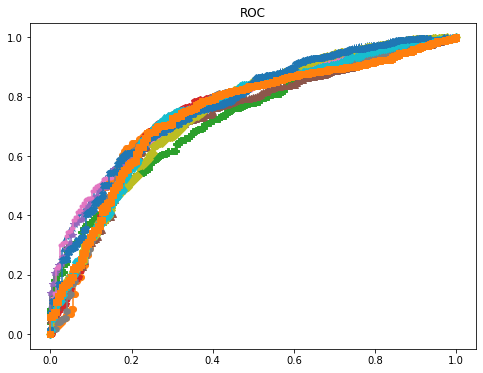

In [53]:
# set up the parameters that will use for fine tunning
clf = Pipeline(steps=[('MLPClassifier', MLPClassifier())])

param_grid = {'MLPClassifier_hidden_layer_sizes': [50, 100],
              'MLPClassifier_activation': ['logistic', 'tanh', 'relu'],
              'MLPClassifier_solver': ['lbfgs', 'sgd']}
hidden_layers = [50, 100]
activations = ['logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd']
combs = list(itertools.product(hidden_layers, activations, solver))

markers = ['2','o','P','p','*','^','.','h','D','d','X','s']
colors = sns.color_palette('Paired', 12)
f1_score_list = []
fig = plt.figure(figsize=(8,6))

for i, para in enumerate(combs):
    print(para)
    clf.set_params(MLPClassifier__hidden_layer_sizes = para[0],
                   MLPClassifier__activation = para[1],
                   MLPClassifier__solver = para[2])
    clf.fit(x_train, y_train)
    pred = clf.predict(x_val)
    f1_score_list.append(f1_score(y_val, pred))
    fpr, tpr, thresholds = roc_curve(y_val, clf.predict_proba(x_val)[:,1])
    plt.plot(fpr, tpr, marker=markers[i])

plt.title("ROC")
print('The combination of hidden layer, activation and solver that yields best result is:', combs[f1_score_list.index(max(f1_score_list))])
print('The f1 score of the model is:', max(f1_score_list))

In [54]:
# Building pipeline for the best MLP
MLP_best = MLPClassifier(hidden_layer_sizes=50, activation='logistic', solver='sgd')
MLP_best.fit(x_train, y_train)
pred_MLP = MLP_best.predict(x_val)
print(confusion_matrix(y_val, pred_MLP))
print('The ROC socore of the best multi-layer perceptron model is: {}'.format(roc_auc_score(y_val, MLP_best.predict_proba(x_val)[:,1])))

[[   0  214]
 [   0 5664]]
The ROC socore of the best multi-layer perceptron model is: 0.7403745247901157


In [436]:
print('The f1 score of the model is:', f1_score(y_val, pred_MLP))
print('AUROC fo the model is:', roc_auc_score(y_val, MLP_best.predict_proba(x_val)[:,1]))
print('Prediction accuracy of best MLP model:', accuracy_score(y_val, pred_MLP))

The f1 score of the model is: 0.9814590192341015
AUROC fo the model is: 0.7392013503880881


## Conclusion

Through Random Forest model's processing time is the longest among all the three models that I have created, it delivers the best performance result in term of AUROC. Thus I will use RandomForest model to predict the classification target in test set.

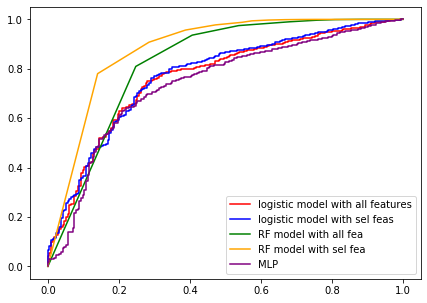

In [459]:
models = [model_logistic_base, best_logi, best_rf, best_rf2, MLP_best]
preds = [pred_logi_base, pred_logi_best, pred_rf, pred_rf2, pred_MLP]
legends = ['logistic model with all features', 'logistic model with sel feas', 'RF model with all fea', 'RF model with sel fea', 'MLP']
colors = ['red', 'blue', 'green', 'orange', 'purple']
x_vals = [x_val, x_val[sel_fea], x_val, x_val[sel_fea_rf], x_val]
plt.figure(figsize=(7,5))
for i, model in enumerate(models):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(x_vals[i])[:,1])
    plt.plot(fpr, tpr, color=colors[i])
plt.legend(legends)

In [479]:
# predict target value on validation set
y_test_rf = best_rf2.predict(x_test[sel_fea_rf])

# attach predicted target result to validation set
result_rf = raw_df.copy()
result_rf['pred success'] = y_test_rf.tolist()+y.tolist()
result_rf = result_rf[['anonID', 'pred success']]

# Export result
result_rf.to_csv('PepsiCo Project Classification Result.csv', index=False)